Loading the usernames and tweets into Pandas dataframe (and save them to a pickle for future use, since this takes time)

In [98]:
import json
import pandas as pd

df = pd.DataFrame(columns=["user", "tweet"])
i = 0

with open('../diabetes_tweets.json', encoding="utf8") as f:
    for row in f:
        jo = json.loads(row)
        df.loc[i] =[jo['user']['screen_name'], jo['text'] ]
        i += 1
        
df.to_pickle('user_and_tweets.bin')

Defining the pre-processing steps

In [104]:
del stop_words[:]

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from stop_words import get_stop_words
import codecs
from spacy.lang.sv import Swedish

stemmer = SnowballStemmer("swedish")
stop_words = stopwords.words('swedish')

stop_words.append('SCREEN_NAME')
stop_words.append('diabetes')
#stop_words.append('diabetiker')

parser = Swedish()

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

def pre_process_text(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in stop_words]
#   tokens = [stemmer.stem(token) for token in tokens] #Removing the stemming because it's not working that good
    return tokens

Demonstrating how the tokenizer works and the list of stop words (or mostly how bad it works if you activate the stemmer we commented out)

In [105]:
test = "hej jag heter marcus och jag äter chips, detta fungerar inte så bra"
print(pre_process_text(test))

print(stop_words)

['heter', 'marcus', 'chips', 'fungerar']
['och', 'det', 'att', 'i', 'en', 'jag', 'hon', 'som', 'han', 'på', 'den', 'med', 'var', 'sig', 'för', 'så', 'till', 'är', 'men', 'ett', 'om', 'hade', 'de', 'av', 'icke', 'mig', 'du', 'henne', 'då', 'sin', 'nu', 'har', 'inte', 'hans', 'honom', 'skulle', 'hennes', 'där', 'min', 'man', 'ej', 'vid', 'kunde', 'något', 'från', 'ut', 'när', 'efter', 'upp', 'vi', 'dem', 'vara', 'vad', 'över', 'än', 'dig', 'kan', 'sina', 'här', 'ha', 'mot', 'alla', 'under', 'någon', 'eller', 'allt', 'mycket', 'sedan', 'ju', 'denna', 'själv', 'detta', 'åt', 'utan', 'varit', 'hur', 'ingen', 'mitt', 'ni', 'bli', 'blev', 'oss', 'din', 'dessa', 'några', 'deras', 'blir', 'mina', 'samma', 'vilken', 'er', 'sådan', 'vår', 'blivit', 'dess', 'inom', 'mellan', 'sådant', 'varför', 'varje', 'vilka', 'ditt', 'vem', 'vilket', 'sitta', 'sådana', 'vart', 'dina', 'vars', 'vårt', 'våra', 'ert', 'era', 'vilkas', 'SCREEN_NAME', 'diabetes']


Tokenizing and saving to a pickle

In [113]:
import pandas as pd
import random
from gensim import corpora
import pickle

# name the setup so we can try different models

# removing the word "diabetiker" from the tokens
model_path = 'models/05-topics-without-diabetiker'
corpus_path = 'models/corpus_without'
dictionary_path = 'models/dictionary_without'

# keeping the word "diabetiker" in the tokens
model_path = 'models/05-topics-with-diabetiker'
corpus_path = 'models/corpus_with'
dictionary_path = 'models/dictionary_with'


df = pd.read_pickle("user_and_tweets.bin")
data = []

for index, row in df.iterrows():
    tokens = pre_process_text(row['tweet']) # we could add the username to the token list to inlude users in topic search
#    remove comments to see 1% of tokens
#    if random.random() > .99:
#        print(tokens)
    data.append(tokens)

dictionary = corpora.Dictionary(data)
corpus = [dictionary.doc2bow(text) for text in data]

pickle.dump(corpus, open(corpus_path, 'wb'))
dictionary.save(dictionary_path)

Visualizing the word frequency with a word cloud

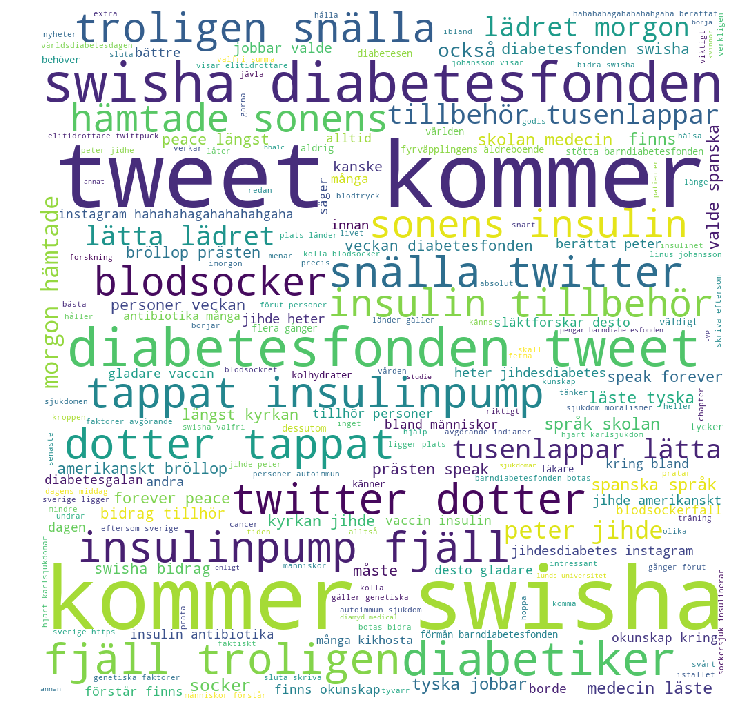

In [125]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_string = ''
for list in data:
    for word in list:
        word_string = word_string + word + ' ' 

wordcloud=WordCloud(width=1000,height=1000, background_color='white', stopwords=stop_words,min_font_size=10).generate(word_string)


plt.figure(figsize=(10,10),facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


Performing the topic search

In [107]:
import gensim
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save(model_path)
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.068*"kommer" + 0.060*"swisha" + 0.059*"diabetesfonden" + 0.055*"tweet"')
(1, '0.040*"insulinpump" + 0.040*"dotter" + 0.040*"snälla" + 0.039*"twitter"')
(2, '0.059*"insulin" + 0.014*"jobbar" + 0.014*"många" + 0.014*"morgon"')
(3, '0.008*"visar" + 0.006*"studie" + 0.006*"diabetiker" + 0.005*"veckan"')
(4, '0.028*"diabetiker" + 0.024*"blodsocker" + 0.013*"sverige" + 0.011*"2-diabetes"')


Visualizing the found topics

In [103]:
import warnings
#warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

# removing the word "diabetiker" from the tokens
model_path = 'models/05-topics-without-diabetiker'
corpus_path = 'models/corpus_without'
dictionary_path = 'models/dictionary_without'

dictionary = gensim.corpora.Dictionary.load(dictionary_path)
corpus = pickle.load(open(corpus_path, 'rb'))
lda = gensim.models.ldamodel.LdaModel.load(model_path)
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [108]:
import warnings
#warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

# keeping the word "diabetiker" in the tokens
model_path = 'models/05-topics-with-diabetiker'
corpus_path = 'models/corpus_with'
dictionary_path = 'models/dictionary_with'

dictionary = gensim.corpora.Dictionary.load(dictionary_path)
corpus = pickle.load(open(corpus_path, 'rb'))
lda = gensim.models.ldamodel.LdaModel.load(model_path)
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)